In [7]:
import numpy as np
from scipy import signal
from skimage.transform import resize
from skimage.io import imread
from scipy.ndimage import filters
from skimage.transform import pyramid_gaussian
from echo_lv.lv import get_contour_points, area2cont, cont2area, interpolate_contour
from echo_lv.data import LV_EKB_Dataset
from skimage.io import imsave
import matplotlib.pyplot as plt

ekb = LV_EKB_Dataset(img_size=(512,512), normalize=True)

Dataset is correct.


In [8]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', unicode=True)
rc('text.latex', preamble=r'\usepackage[russian]{babel}')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
imgs, msks = ekb.get_sequence('21', 'Norma_Old')

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(imgs[0], cmap=plt.cm.gray)
plt.axis('Off')
plt.subplot(122)
plt.imshow(imgs[0], cmap=plt.cm.gray)
cont_x, cont_y = np.where(area2cont(msks[0]) != 0)
plt.scatter(cont_y, cont_x, s=5, color='g', marker='.')
plt.axis('Off')
# plt.savefig('us.png', bbox_inches='tight', pad_inches=0)

In [ ]:
from echo_lv.segmentation.optical_flow import LucasKanade
lk = LucasKanade(gauss_layers=2, window=61)
# pred_msks = lk.get_points(imgs, msks[0])
pred_msks = lk.predict(imgs, msks[0])

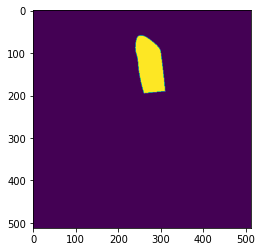

In [7]:
plt.imshow(pred_msks[10])

In [7]:
def window_image(img, cent_point, window):
    y0 = int(np.round(cent_point[0]) - window // 2)
    y1 = int(np.round(cent_point[0]) + window // 2 + 1)
    x0 = int(np.round(cent_point[1]) - window // 2)
    x1 = int(np.round(cent_point[1]) + window // 2 + 1)
    if x0 < 0:
        x0 = 0
    if y0 < 0:
        y0 = 0
    if y1 > img.shape[0]:
        y1 = img.shape[0]
    if x1 > img.shape[1]:
        x1 = img.shape[1]    
    img = img[y0:y1, x0:x1]
    if img.shape[0] != window:
        if y0 == 0:
            img = np.concatenate((np.zeros((window - img.shape[0], img.shape[1])), img), axis=0)
        elif y1 == img.shape[0]:
            img = np.concatenate((img, np.zeros((window - img.shape[0], img.shape[1]))), axis=0)
    if img.shape[1] != window:
        if x0 == 0:
            img = np.concatenate((np.zeros((img.shape[0], window - img.shape[1])), img), axis=1)
        elif x1 == img.shape[1]:
            img = np.concatenate((img, np.zeros((img.shape[0], window - img.shape[1]))), axis=1)
    return img

In [8]:
cont_x, cont_y, *_ = get_contour_points(msks[0], kind='contour', num = 9) 
points = [(y, x) for x, y in zip(cont_x, cont_y)]
index = 0

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


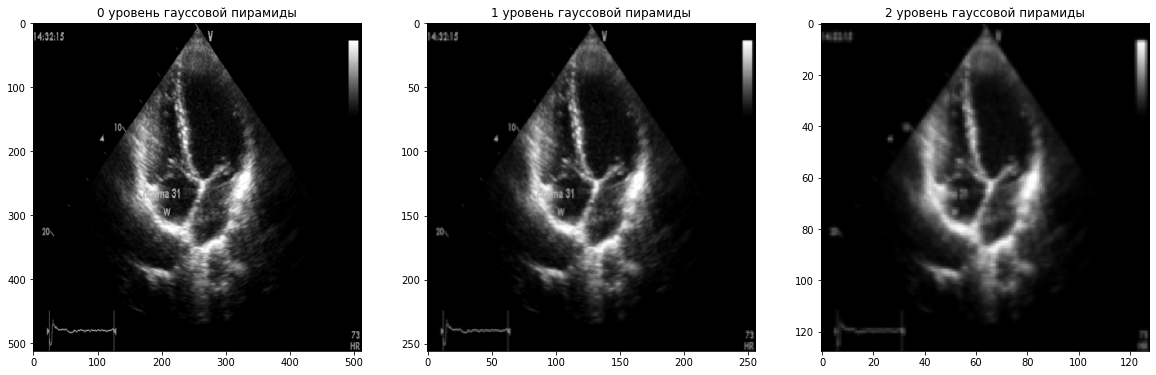

In [9]:
layers = 2
r_1_imgs = pyramid_gaussian(imgs[0], max_layer=layers)
r_2_imgs = pyramid_gaussian(imgs[1], max_layer=layers)
r_1_imgs = list(r_1_imgs)
r_2_imgs = list(r_2_imgs)
plt.figure(figsize=(20,10))
for i, img in enumerate(r_1_imgs):
    plt.subplot(1,len(r_1_imgs),i+1)
    plt.imshow(img, cmap=plt.cm.gist_gray)
    plt.title(str(i) + ' уровень гауссовой пирамиды')
# plt.savefig('optical_flow/gauss_pyramid.png', bbox_inches='tight', pad_inches=0)

In [10]:
# imgs, msks = ekb.get_sequence('04', 'Norma')
# imgs, msks = ekb.get_sequence('21', 'Norma_Old')
imgs, msks = ekb.get_sequence('05', 'DKMP')

layers = 2
window = 61

cont_x, cont_y, *_ = get_contour_points(msks[0], kind='contour', num = 9) 
points = [(y, x) for x, y in zip(cont_x, cont_y)]
of = [points]

for ind in range(0, len(imgs)-1):
    r_1_imgs = list(pyramid_gaussian(imgs[ind], max_layer=layers))
    r_2_imgs = list(pyramid_gaussian(imgs[ind+1], max_layer=layers))
    new_points = []
    for point in points:
        flow = np.array([[0], [0]])
        for l, (img_1, img_2) in enumerate(zip(r_1_imgs[::-1], r_2_imgs[::-1])):

            img1 = window_image(img_1, (point[0] / 2 ** (layers - l), 
                                        point[1] / 2 ** (layers - l)), window)
            img2 = window_image(img_2, ((point[0] + flow[1]) / 2 ** (layers - l), 
                                        (point[1] + flow[0]) / 2 ** (layers - l)), window)

            f_y, f_x = np.gradient(img1)
            f_t = img1 - img2
            A = np.array([[np.sum(f_x ** 2), np.sum(f_x * f_y)],
                         [np.sum(f_x * f_y), np.sum(f_y ** 2)]])
            B = np.array([[np.sum(f_x * f_t)],
                        [np.sum(f_y * f_t)]
                         ])
            solv_flow = np.matmul(np.linalg.inv(A), B)
            flow = 2*(flow + solv_flow)
        new_points.append((point[0] + int(flow[1]), point[1] + int(flow[0])))
    points = new_points
    of.append(points)


## Примеры использования 

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


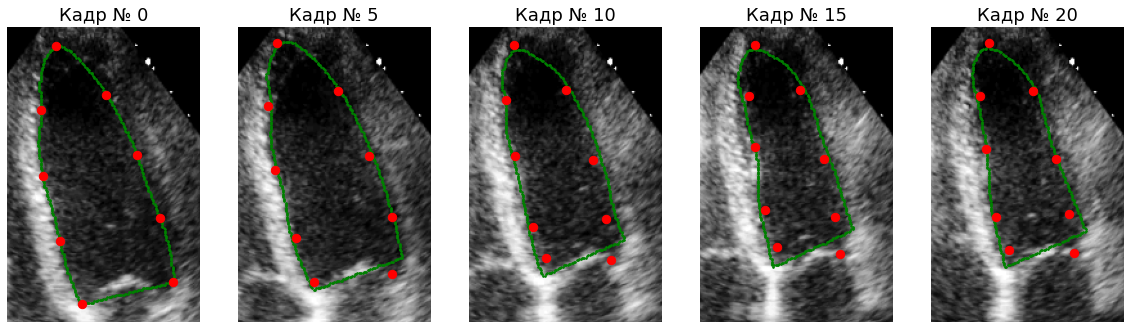

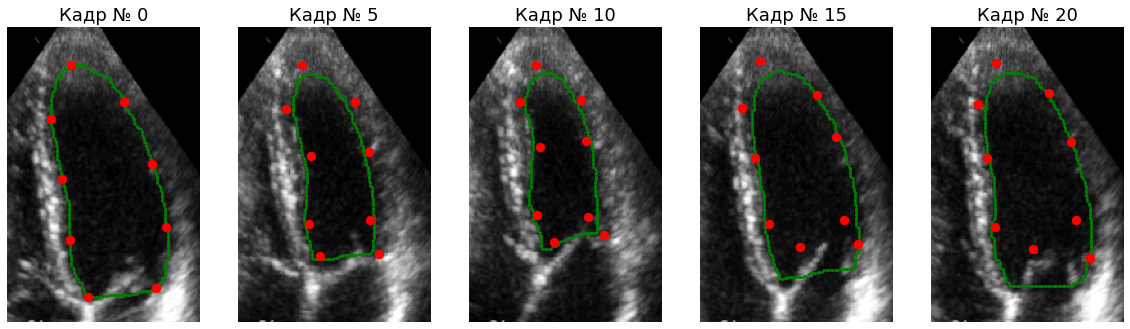

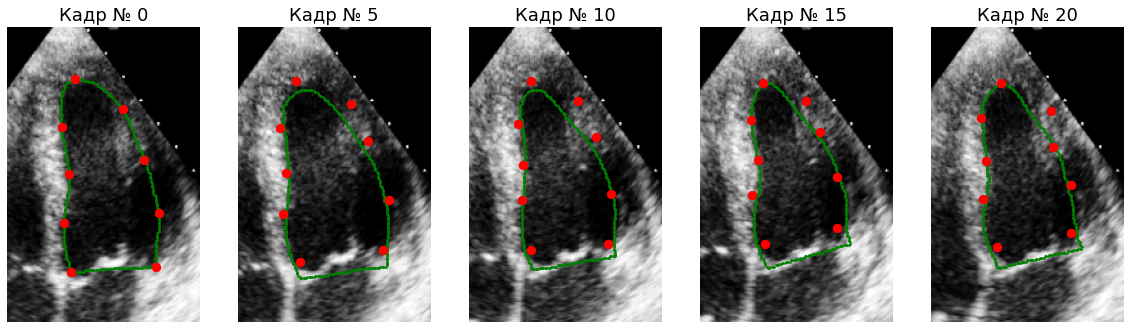

In [3]:
from echo_lv.segmentation.optical_flow import LucasKanade
# print(index)

step = 5
lk = LucasKanade(gauss_layers=1, window=15)
for p_i, obj in enumerate([{'pat' : '04', 'cat' : 'Norma'}, {'pat' : '21', 'cat' : 'Norma_Old'}, {'pat' : '05', 'cat' : 'DKMP'}]):
    plt.figure(figsize=(20,10))
    imgs, msks = ekb.get_sequence(obj['pat'], obj['cat'])
    cont_x, cont_y, *_ = get_contour_points(area2cont(msks[0]), kind='contour', num = 9)
    points = [(y, x) for x, y in zip(cont_x, cont_y)]
    results = lk.get_points(imgs, points)
    for i, (img, msk) in enumerate(zip(imgs[::step], msks[::step])):
        plt.subplot(1, 5, i+1)
        cont_x, cont_y = np.where(area2cont(msk) != 0)

        x = [p[1] for p in results[step*i]]
        y = [p[0] for p in results[step*i]]
        plt.imshow(imgs[step*i], cmap=plt.cm.gray)
        plt.scatter(cont_y, cont_x, s=10, color='g', marker='.')
        plt.scatter(x, y, s=70, color='r', marker='o')
        if p_i == 0:
            plt.xlim(215, 365)
            plt.ylim(130, 360)
        elif p_i == 1:
            plt.xlim(200, 350)
            plt.ylim(30, 260)
        elif p_i == 2:
            plt.xlim(225, 375)
            plt.ylim(105, 335)

        plt.gca().invert_yaxis()
        plt.axis('off')
        plt.title('Кадр № ' + str(step*i), fontsize=18)
        if i == 4:
            break
#     plt.savefig('optical_flow/result_optical_flow_'+str(p_i + 1) +'.png', bbox_inches='tight', pad_inches=0)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: No contour levels were found within the data range.


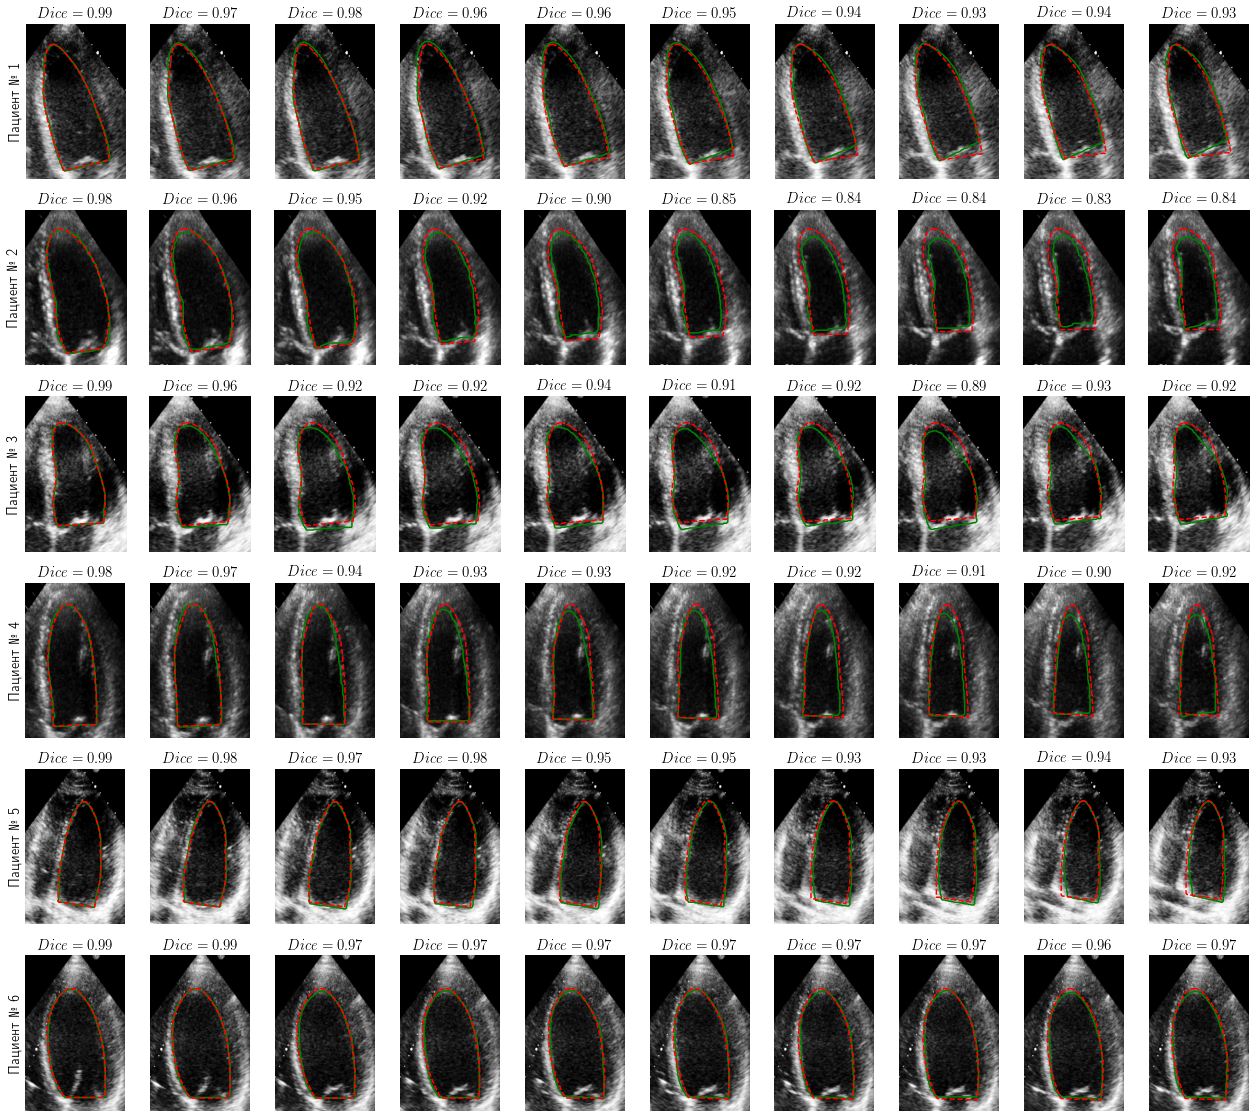

In [33]:
from echo_lv.metrics import dice, jaccard
from echo_lv.segmentation.optical_flow import LucasKanade

lk = LucasKanade(gauss_layers=1, window=61)
patients = [{'pat' : '04', 'cat' : 'Norma'}, 
            {'pat' : '21', 'cat' : 'Norma_Old'}, 
            {'pat' : '05', 'cat' : 'DKMP'},
            {'pat' : '10', 'cat' : 'Pathology_Old'},
            {'pat' : '03', 'cat' : 'Norma'},
            {'pat' : '01', 'cat' : 'DKMP'},
           ]

plt.figure(figsize=(22,20))
for num, obj in enumerate(patients):
    imgs, msks = ekb.get_sequence(obj['pat'], obj['cat'])
    pred_msks = lk.predict(imgs, msks[0])
    for i, (img, msk, p_msk) in enumerate(zip(imgs, msks, pred_msks)):
        plt.subplot(len(patients), 10, 10*num+i+1)
        d = dice(msk, p_msk)
#         cont_x, cont_y = np.where(area2cont(msk) != 0)
#         p_cont_x, p_cont_y = np.where(area2cont(p_msk) != 0)

        plt.imshow(imgs[i], cmap=plt.cm.gray)
        plt.contour(msk, 0, colors = 'g');
        plt.contour(p_msk, 0, colors = 'r', linestyles='dashed');
#         plt.scatter(cont_y, cont_x, s=1, color='g', marker='.')
#         plt.scatter(p_cont_y[::10], p_cont_x[::10], s=1, color='r', marker='o')
        if obj['pat'] == '04' and obj['cat'] == 'Norma':
            plt.xlim(210, 370)
            plt.ylim(110, 360)
            x = 200
            y = (360 - 110) / 2 + 110
        elif obj['pat'] == '21' and obj['cat'] == 'Norma_Old':
            plt.xlim(200, 350)
            plt.ylim(30, 260)
            x = 190
            y = (260 - 30) / 2 + 30
        elif obj['pat'] == '05' and obj['cat'] == 'DKMP':
            plt.xlim(225, 375)
            plt.ylim(105, 335)
            x = 215
            y = (335 - 105) / 2 + 105
        elif obj['pat'] == '10' and obj['cat'] == 'Pathology_Old':
            plt.xlim(180, 360)
            plt.ylim(60, 340)
            x = 170
            y = (340 - 60) / 2 + 60
        elif obj['pat'] == '03' and obj['cat'] == 'Norma':
            plt.xlim(180, 360)
            plt.ylim(100, 380)
            x = 170
            y = (380 - 100) / 2 + 100
        elif obj['pat'] == '01' and obj['cat'] == 'DKMP':
            plt.xlim(180, 360)
            plt.ylim(100, 380)
            x = 170
            y = (380 - 100) / 2 + 100
        
        plt.axis('off')
        if i == 0:
            plt.text(x, y, 'Пациент № ' + str(num+1), fontsize=15, ha='center', rotation=90, rotation_mode='anchor')
        plt.gca().invert_yaxis()
        plt.title(r'$Dice={:.2f}$'.format(d), fontsize=15)
        if i == 9:
            break
plt.savefig('optical_flow/example_lk_appendix.png', dpi=300, bbox_inches='tight', pad_inches=0)

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: No contour levels were found within the data range.
  
/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: No contour levels were found within the data range.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, '$Dice=0.97$')

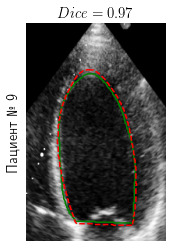

In [28]:
 plt.imshow(imgs[i], cmap=plt.cm.gray)
plt.contour(msk, 0, colors = 'g');
plt.contour(p_msk, 0, colors = 'r', linestyles='dashed');
#         plt.scatter(cont_y, cont_x, s=1, color='g', marker='.')
#         plt.scatter(p_cont_y[::10], p_cont_x[::10], s=1, color='r', marker='o')
if obj['pat'] == '04' and obj['cat'] == 'Norma':
    plt.xlim(210, 370)
    plt.ylim(110, 360)
    x = 200
    y = (360 - 110) / 2
elif obj['pat'] == '21' and obj['cat'] == 'Norma_Old':
    plt.xlim(200, 350)
    plt.ylim(30, 260)
elif obj['pat'] == '05' and obj['cat'] == 'DKMP':
    plt.xlim(225, 375)
    plt.ylim(105, 335)
elif obj['pat'] == '10' and obj['cat'] == 'Pathology_Old':
    plt.xlim(180, 360)
    plt.ylim(60, 340)
elif obj['pat'] == '03' and obj['cat'] == 'Norma':
    plt.xlim(180, 360)
    plt.ylim(100, 380)
elif obj['pat'] == '01' and obj['cat'] == 'DKMP':
    plt.xlim(180, 360)
    plt.ylim(100, 380)
    x = 170
    y = (380 - 100) / 2 + 100
plt.axis('off')
plt.text(x, y, 'Пациент № ' + str(i), fontsize=15, ha='center', rotation=90, rotation_mode='anchor')
plt.gca().invert_yaxis()
plt.title(r'$Dice={:.2f}$'.format(d), fontsize=15)

# Вычисления

In [9]:
from tqdm import tqdm
import numpy as np
from echo_lv.data import LV_EKB_Dataset
from echo_lv.segmentation.optical_flow import LucasKanade
from echo_lv.metrics import dice, jaccard
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
ekb = LV_EKB_Dataset(dataset_path='/home/vasily/datasets/us_ekb', img_size=(512,512), normalize=True, shuffle=False)

Dataset is correct.


In [64]:
res = {}
max_window = 60
for l in range(2,3):
    tmp_res = {}
    for k in np.arange(55, max_window + 1, 1):
        lk = LucasKanade(gauss_layers=l, window=2*k+1)
        results = {'dice' : [], 'jaccard' : [], 'info' : []}
        for i, (pat, cat, *_) in tqdm(ekb.df_patients.iterrows(), total=len(ekb.df_patients), leave=False, desc=str(k)):
            imgs, masks = ekb.get_sequence(pat, cat)
            pred_msks = lk.predict(imgs, masks[0])
            for ind, (pred_msk, msk) in enumerate(zip(pred_msks, masks)):
                d = dice(msk, pred_msk)
#                 j = jaccard(msk, pred_msk)
                results['dice'].append(d)
#                 res['jaccard'].append(j)
                results['info'].append([ind, pat, cat])
        tmp_res[k] = results
    res[l] = tmp_res

55:   0%|          | 0/94 [00:00<?, ?it/s]/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [66]:
prep_res = {}
for l in res.keys():
    tmp = {}
    for k in res[l].keys():
        if k != 15:
            tmp[k] = res[l][k]['dice']
    prep_res[l] = tmp

In [68]:
l = 2
df_add = pd.DataFrame(prep_res[l])
df = pd.read_csv('optical_flow/results/dist_window_lk_level_' + str(l) + '.csv')
df = pd.concat((df, df_add ), axis=1)
df.to_csv('optical_flow/results/dist_window_lk_level_' + str(l) + '.csv', index=False)

In [16]:
prep_res = {}
for l in results.keys():
    tmp = {}
    for k in results[l].keys():
        tmp[k] = res[l][k]['dice']
    prep_res[l] = tmp

In [18]:
import pandas as pd
for l in res.keys():
    df = pd.DataFrame(res[l])
    df.to_csv('optical_flow/results/dist_window_lk_level_'+str(l)+'.csv', index=False)

In [ ]:
import pandas as pd
df = pd.DataFrame(res)
df.to_csv('optical_flow/results/dist_window_lk_level_0.csv', index=False)

In [63]:
df = pd.read_csv('optical_flow/results/dist_window_lk_level_2.csv')
df

,5,6,7,8,9,10,11,12,13,14,...,46,47,48,49,50,51,52,53,54,55
0,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,...,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750,0.990750
1,0.983520,0.984590,0.983558,0.986351,0.980796,0.984123,0.981737,0.987343,0.980855,0.986350,...,0.990199,0.990517,0.990517,0.990517,0.990517,0.990517,0.990904,0.989516,0.989516,0.989516
2,0.969896,0.972583,0.970433,0.972437,0.968340,0.969082,0.970185,0.971025,0.969054,0.973828,...,0.974098,0.973439,0.973439,0.973439,0.973439,0.973479,0.974917,0.974441,0.973529,0.973529
3,0.952731,0.964272,0.963810,0.975073,0.965164,0.967456,0.963271,0.969299,0.972361,0.975360,...,0.976420,0.975693,0.975693,0.975693,0.975693,0.974217,0.975733,0.976180,0.974790,0.974790
4,0.940167,0.960207,0.955909,0.967248,0.946775,0.953301,0.952314,0.957366,0.959657,0.960884,...,0.972675,0.971112,0.969522,0.971767,0.971767,0.969534,0.969752,0.969604,0.965895,0.965895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,0.725216,0.725049,0.738481,0.792443,0.745442,0.764668,0.753255,0.763146,0.773686,0.775999,...,0.870287,0.865412,0.877720,0.850420,0.862155,0.858966,0.877852,0.871165,0.869330,0.859047
2767,0.730905,0.740916,0.757774,0.819255,0.766118,0.784674,0.775453,0.780840,0.799175,0.796405,...,0.884563,0.880061,0.893427,0.866379,0.880650,0.877727,0.891298,0.884118,0.886408,0.873858
2768,0.681012,0.729265,0.726940,0.767797,0.758743,0.783288,0.771670,0.755877,0.788465,0.791957,...,0.878818,0.874150,0.878163,0.862781,0.866179,0.873742,0.880883,0.883473,0.862120,0.844394
2769,0.673330,0.750817,0.733095,0.788171,0.778465,0.802191,0.774959,0.768306,0.789889,0.797855,...,0.891501,0.889611,0.896486,0.873721,0.888731,0.884551,0.892853,0.890199,0.875772,0.863642


In [70]:
import os
path = 'optical_flow/results/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('dist')]
files

['optical_flow/results/dist_window_lk_level_1.csv',
 'optical_flow/results/dist_window_lk_level_0.csv',
 'optical_flow/results/dist_window_lk_level_2.csv']

In [71]:
dist_norm = lambda x : np.exp(- x ** 2 / 2) / (2 * np.pi) ** (1/2)

dict_hs = {}
hs = {1: [0.007600000000000007,
  0.0034599999999999982,
  0.004199999999999998,
  0.0032999999999999987,
  0.003799999999999998,
  0.00479,
  0.004199999999999998,
  0.003689999999999998,
  0.004499999999999999,
  0.00258,
  0.005000000000000005,
  0.0036000000000000034,
  0.004560000000000006,
  0.005470000000000008,
  0.005040000000000008,
  0.003710000000000005,
  0.006130000000000011,
  0.005880000000000013,
  0.005790000000000012,
  0.005450000000000013,
  0.005770000000000013,
  0.005320000000000014,
  0.006080000000000018,
  0.00634000000000002,
  0.006210000000000021,
  0.0070000000000000236,
  0.00570000000000002,
  0.006210000000000021,
  0.004290000000000017,
  0.005870000000000022,
  0.005440000000000022,
  0.005960000000000023,
  0.005960000000000023,
  0.006720000000000026,
  0.006220000000000025,
  0.006000000000000025,
  0.005800000000000002,
  0.004560000000000001,
  0.005170000000000002,
  0.004770000000000001,
  0.0049,
  0.0052100000000000046,
  0.004630000000000002,
  0.004299999999999998,
  0.004950000000000002,
  0.004389999999999999,
  0.004059999999999999,
  0.0038999999999999977,
  0.003179999999999999,
  0.004299999999999998,
  0.0037599999999999977,
  0.003599999999999998,
  0.003599999999999998,
  0.003699999999999998,
  0.004099999999999998,
  0.0038999999999999977],
 0: [0.0039999999999999975,
  0.003799999999999998,
  0.0051,
  0.003799999999999998,
  0.004699999999999999,
  0.0038999999999999977,
  0.0038699999999999976,
  0.0042699999999999995,
  0.00437,
  0.004699999999999999,
  0.004800000000000005,
  0.004200000000000003,
  0.003580000000000004,
  0.0045700000000000055,
  0.00563000000000001,
  0.004850000000000007,
  0.004530000000000007,
  0.00489000000000001,
  0.005160000000000012,
  0.005750000000000014,
  0.005260000000000012,
  0.005410000000000015,
  0.005300000000000015,
  0.005640000000000018,
  0.005050000000000016,
  0.0056100000000000195,
  0.0049700000000000195,
  0.005510000000000019,
  0.004790000000000018,
  0.005190000000000019,
  0.00496000000000002,
  0.005230000000000022,
  0.005140000000000021,
  0.005120000000000022,
  0.005390000000000024,
  0.005010000000000022,
  0.0049,
  0.004750000000000002,
  0.005200000000000001,
  0.005470000000000003,
  0.005200000000000001,
  0.004560000000000001,
  0.005050000000000002,
  0.0051,
  0.004760000000000001,
  0.00489,
  0.004980000000000001,
  0.00457,
  0.00447,
  0.0043999999999999985,
  0.0039999999999999975,
  0.004499999999999999,
  0.004099999999999998,
  0.0038999999999999977,
  0.00426,
  0.003799999999999998],
 2: [0.01274999999999998,
  0.007770000000000009,
  0.01114999999999999,
  0.007970000000000008,
  0.005800000000000002,
  0.006360000000000005,
  0.003599999999999998,
  0.005680000000000003,
  0.004660000000000001,
  0.005200000000000001,
  0.006300000000000009,
  0.0043000000000000035,
  0.0062800000000000095,
  0.005070000000000007,
  0.005060000000000007,
  0.005650000000000009,
  0.006630000000000013,
  0.006490000000000014,
  0.005590000000000012,
  0.005470000000000012,
  0.005070000000000011,
  0.00403000000000001,
  0.0048000000000000135,
  0.004550000000000015,
  0.006150000000000019,
  0.006110000000000021,
  0.004910000000000018,
  0.004010000000000015,
  0.00549000000000002,
  0.004690000000000018,
  0.00506000000000002,
  0.004760000000000019,
  0.005360000000000021,
  0.005620000000000023,
  0.006220000000000025,
  0.003820000000000019,
  0.005800000000000002,
  0.006960000000000007,
  0.007300000000000006,
  0.006480000000000005,
  0.0059000000000000025,
  0.005360000000000003,
  0.006550000000000006,
  0.0059000000000000025,
  0.006860000000000007,
  0.006290000000000004,
  0.006850000000000007,
  0.0067000000000000046,
  0.007200000000000006,
  0.006600000000000004,
  0.0062500000000000056,
  0.0062500000000000056,
  0.006860000000000007,
  0.007080000000000006,
  0.006860000000000007,
  0.006950000000000007,
  0.007200000000000006]}

for file in files:
    df = pd.read_csv(file)
    level = int(file[-5])
    res = []
    for it, d in tqdm(enumerate(df.iteritems()), total=df.shape[1]):
        direction = 1e-4
        a = np.array(d[1])
        f = -np.Inf
        if it < len(hs[level]):
            h = hs[level][it]
        else:
            h = 0.005
        flag = True
        while abs(direction) >= 1e-5: 
            l = []
            h += direction
            if h <= 0:
                print('!')
                break 
            for i in range(len(a)):
                l.append(np.log(np.sum([dist_norm((a[i] - a[j]) / h) for j in range(len(a)) if i != j]) / (len(a) - 1) / h))
            r = np.sum(l) / len(a)              
            if r < f:
                h -= direction
                if flag:
                    direction = -direction
                    flag = False
                else:
                    direction = direction * 1e-1
            else:
                f = r
        res.append(h)   
    dict_hs[level] = res

100%|██████████| 57/57 [3:11:24<00:00, 201.49s/it]   


In [73]:
dist_norm = lambda x : np.exp(- x ** 2 / 2) / (2 * np.pi) ** (1/2) 

def pz_approx(a, h, kernel, nums):
    t = np.linspace(min(a), max(a), nums)
    f = np.zeros(t.shape)
    for i in range(len(t)):
        for j in range(len(a)):
            f[i] += 1 / (len(a) * h) * np.sum(kernel((t[i] - a[j]) / h))
    return f

In [74]:
def get_quartiles(x, a):
    y = np.cumsum(a) / np.sum(a)
    indexes = np.argsort(abs(y - 0.05))[:2]
    q5 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.5))[:2]
    q50 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.95))[:2]
    q95 = x[indexes][0]
    return q5, q50, q95

100%|██████████| 3/3 [14:50<00:00, 296.75s/it]


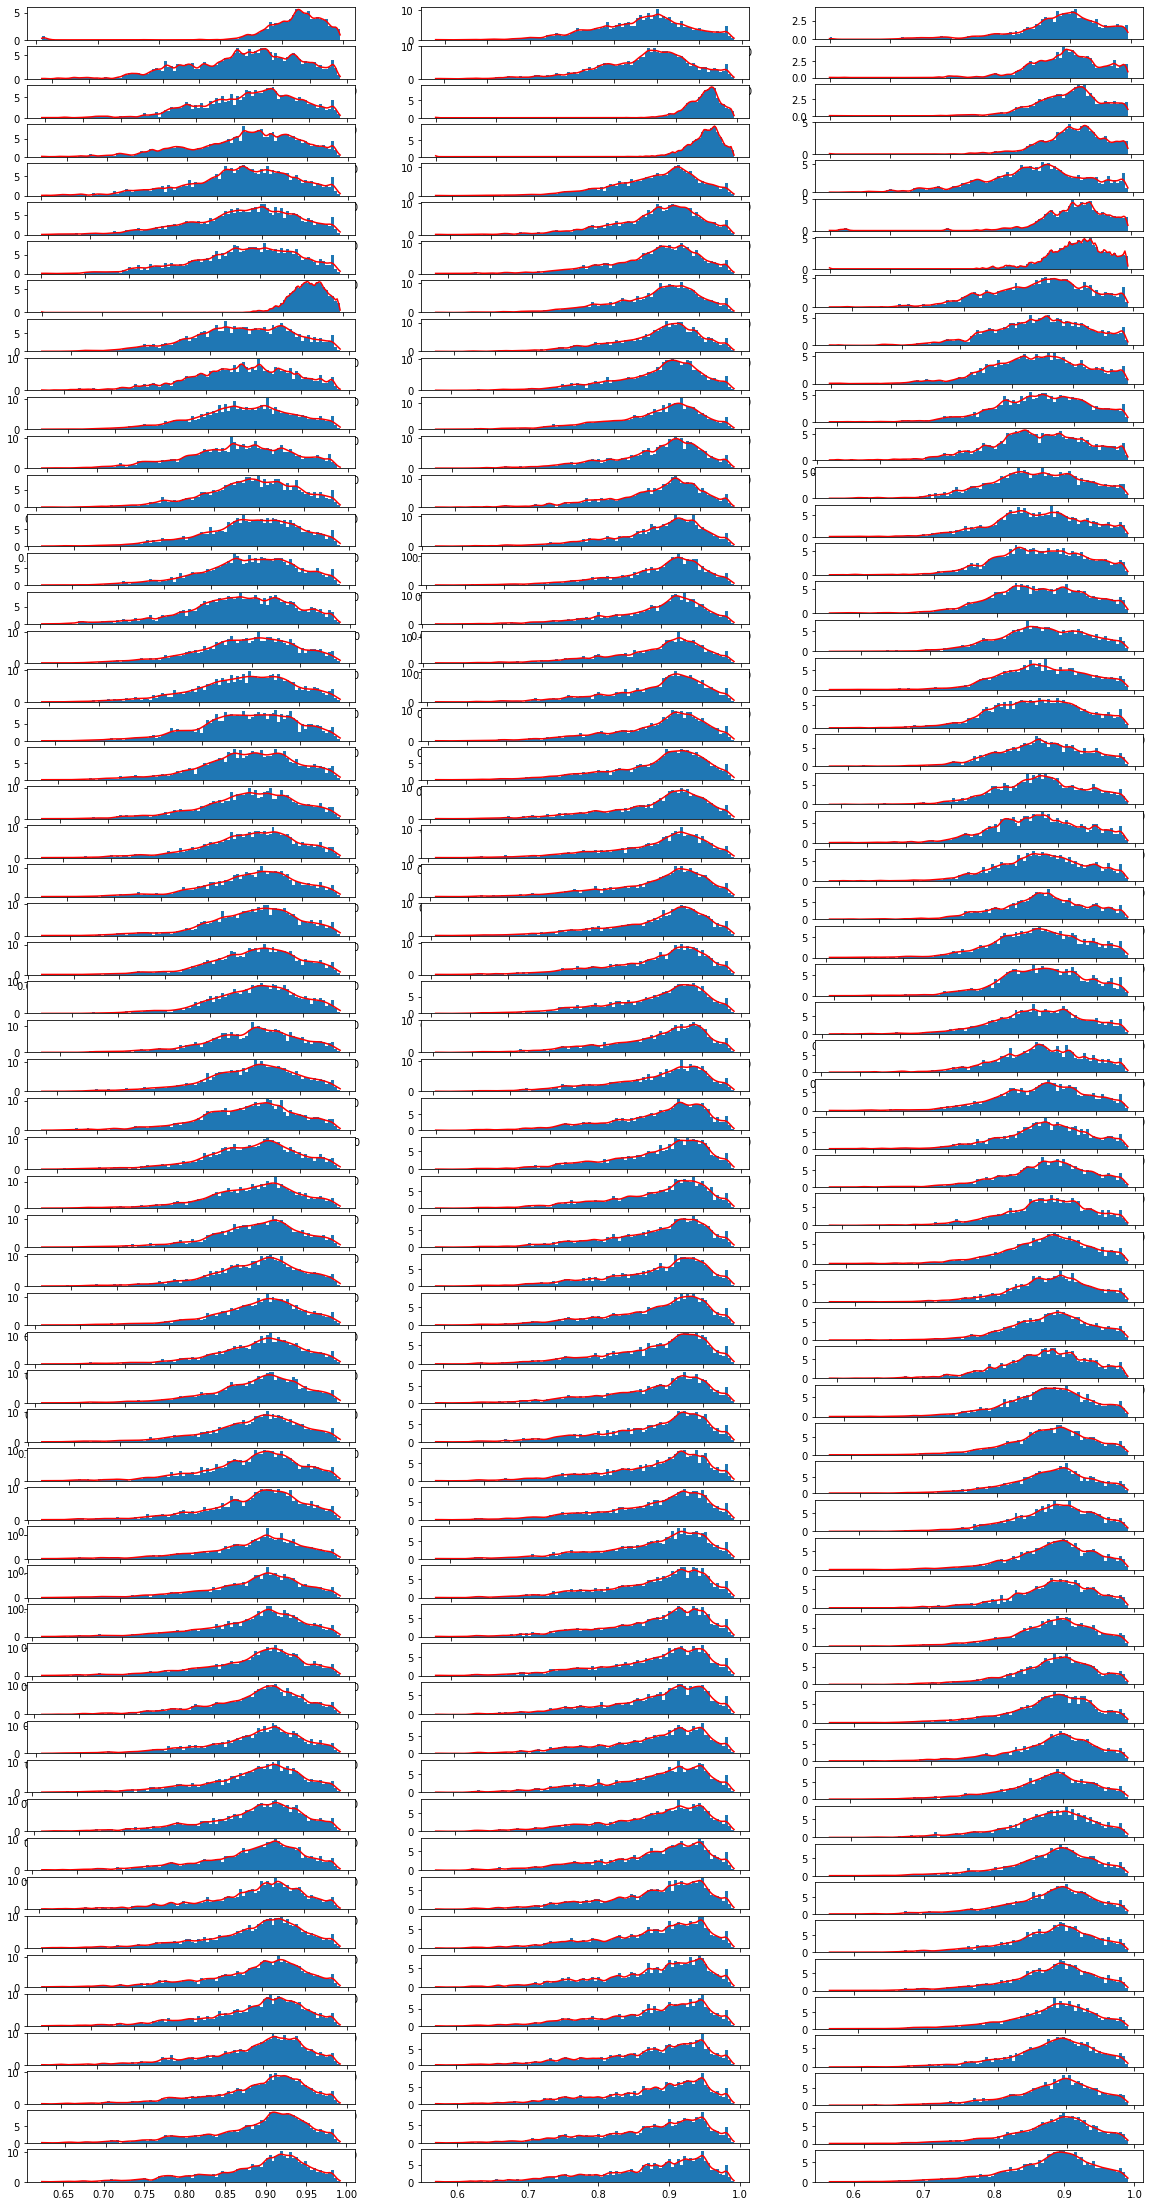

In [75]:
plt.figure(figsize=(20,40))
num_points = 200
dict_q5 = {}
dict_q50 = {}
dict_q95 = {}
for it, file in tqdm(enumerate(files), total=len(files)):
    df = pd.read_csv(file)
    level = int(file[-5])
    q5s = []
    q50s = []
    q95s = []
    for num, d in enumerate(df.iteritems()):
        a = np.array(d[1])
        hist, x, *_ = np.histogram(a, bins=100);
        hist = hist / sum(hist) / (x[1] - x[0])
        plt.subplot(df.shape[1], len(files), len(files) * num + 1 + it)
        plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
        t = np.linspace(min(a), max(a), num_points)
        f = pz_approx(a, dict_hs[level][num], dist_norm, num_points)
        q5, q50, q95 = get_quartiles(t, f)
        q50s.append(q50)
        q5s.append(q5)
        q95s.append(q95)
        plt.plot(t, f, 'r')
    dict_q5[level] = q5s
    dict_q50[level] = q50s
    dict_q95[level] = q95s

In [87]:
p

4.6333905133206065e-07

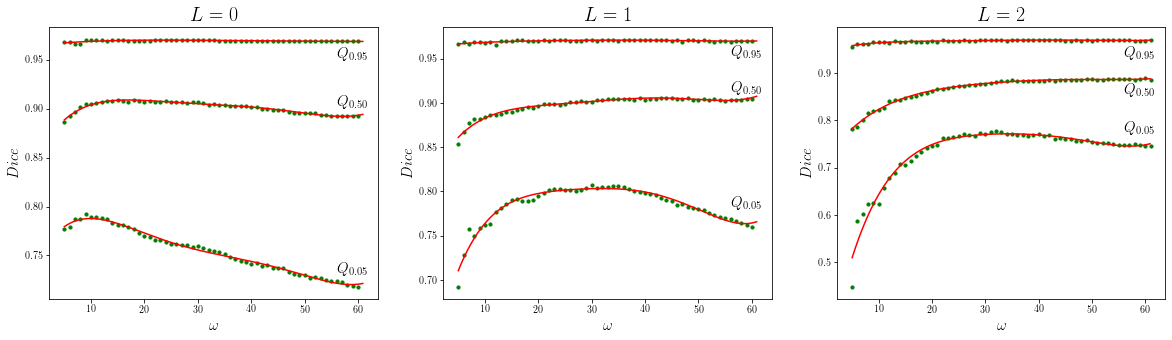

In [147]:
t = np.arange(5, len(dict_q5[0])+5, 0.1)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.scatter(np.arange(5, len(dict_q5[0])+5, 1), dict_q5[0], s=10, c='g', label='О уровней')
p = np.polyfit(np.arange(5, len(dict_q5[0])+5, 1), dict_q5[0], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.73, r'$Q_{0.05}$', fontsize=15)
plt.scatter(np.arange(5, len(dict_q50[0])+5, 1), dict_q50[0], s=10, c='g', label='О уровней')
p = np.polyfit(np.arange(5, len(dict_q50[0])+5, 1), dict_q50[0], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.90, r'$Q_{0.50}$', fontsize=15)
plt.scatter(np.arange(5, len(dict_q95[0])+5, 1), dict_q95[0], s=10, c='g', label='О уровней')
p = np.polyfit(np.arange(5, len(dict_q95[0])+5, 1), dict_q95[0], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.title(r'$L = 0$', fontsize=20)
plt.text(56, 0.95, r'$Q_{0.95}$', fontsize=15)
plt.xlabel(r'$\omega$', fontsize=15)
plt.ylabel(r'$Dice$', fontsize=15)

plt.subplot(132)
plt.scatter(np.arange(5, len(dict_q5[1])+5, 1), dict_q5[1], s=10, c='g', label='1 уровней')
p = np.polyfit(np.arange(5, len(dict_q5[1])+5, 1), dict_q5[1], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.78, r'$Q_{0.05}$', fontsize=15)
plt.scatter(np.arange(5, len(dict_q50[1])+5, 1), dict_q50[1], s=10, c='g', label='1 уровней')
p = np.polyfit(np.arange(5, len(dict_q50[1])+5, 1), dict_q50[1], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.91, r'$Q_{0.50}$', fontsize=15)
plt.scatter(np.arange(5, len(dict_q95[1])+5, 1), dict_q95[1], s=10, c='g', label='1 уровней')
p = np.polyfit(np.arange(5, len(dict_q95[1])+5, 1), dict_q95[1], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.title(r'$L = 1$', fontsize=20)
plt.text(56, 0.95, r'$Q_{0.95}$', fontsize=15)
plt.xlabel(r'$\omega$', fontsize=15)
plt.ylabel(r'$Dice$', fontsize=15)

plt.subplot(133)
plt.scatter(np.arange(5, len(dict_q5[2])+5, 1), dict_q5[2], s=10, c='g', label='2 уровней')
p = np.polyfit(np.arange(5, len(dict_q95[2])+5, 1), dict_q5[2], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.77, r'$Q_{0.05}$', fontsize=15)
plt.scatter(np.arange(5, len(dict_q50[2])+5, 1), dict_q50[2], s=10, c='g', label='2 уровней')
p = np.polyfit(np.arange(5, len(dict_q95[2])+5, 1), dict_q50[2], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.85, r'$Q_{0.50}$', fontsize=15)
plt.scatter(np.arange(5, len(dict_q95[2])+5, 1), dict_q95[2], s=10, c='g', label='2 уровней')
p = np.polyfit(np.arange(5, len(dict_q95[2])+5, 1), dict_q95[2], 5)
y = np.polyval(p, t)
plt.plot(t, y, 'r')
plt.text(56, 0.93, r'$Q_{0.95}$', fontsize=15)
plt.title(r'$L = 2$', fontsize=20)
plt.xlabel(r'$\omega$', fontsize=15)
plt.ylabel(r'$Dice$', fontsize=15)
plt.savefig('optical_flow/result_for_levels_lk_quartiles.eps', bbox_inches='tight', pad_inches=0)

In [138]:
index = np.argmax(dict_q5[0])
print(dict_q95[0][index] - dict_q5[0][index])
print(dict_q50[0][index])

0.17772975790915457
0.9043659366564056


In [148]:
index = np.argmax(dict_q5[1])
print(dict_q5[1][index], dict_q50[1][index], dict_q95[1][index])
print(dict_q95[1][index] - dict_q5[1][index])
print(dict_q50[1][index])

0.8070670015573909 0.9013466378887021 0.9712436096515706
0.16417660809417978
0.9013466378887021


In [141]:
index = np.argmax(dict_q5[2])
print(np.arange(5, len(dict_q5[2])+5, 1)[index])
print(dict_q95[2][index] - dict_q5[2][index])
print(dict_q50[2][index])

32
0.1927322037869581
0.8819800817433879


In [12]:
df = pd.read_csv('optical_flow/results/dist_window_lk_level_1.csv')[str(30)]
df.to_csv('optical_flow/results/lk.csv', header=True, index=False,)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
         3.,  1.,  1.,  0.,  1.,  2.,  2.,  1.,  2.,  0.,  1.,  1.,  4.,
         2.,  1.,  3.,  1.,  3.,  6.,  1.,  2.,  2.,  3.,  1.,  8., 12.,
         8., 11., 11., 10., 15., 14., 13., 17., 22., 16., 12., 16., 21.,
        25., 30., 20., 45., 35., 47., 54., 64., 66., 72., 71., 59., 65.,
        65., 67., 67., 82., 62., 76., 81., 71., 71., 71., 73., 71., 55.,
        63., 72., 55., 79., 67., 53., 39., 41., 38., 45., 55., 47., 31.,
        27., 32., 39., 49., 22., 19., 50., 20.,  9.]),
 array([0.59437904, 0.59834274, 0.60230645, 0.60627016, 0.61023386,
        0.61419757, 0.61816128, 0.62212498, 0.62608869, 0.6300524 ,
        0.63401611, 0.63797981, 0.64194352, 0.64590723, 0.64987093,
        0.65383464, 0.65779835, 0.66176206, 0.66572576, 0.66968947,
        0.67365318, 0.67761688, 0.68158059, 0.6855443 , 0.689508  ,
        0.69347171, 0.69743542, 0.70139913, 0.70536283, 0.70932654,
        0.71329025, 0.7172

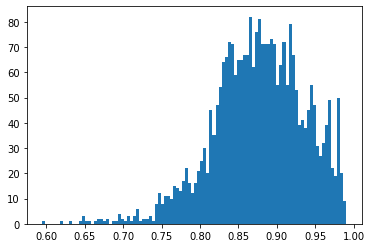

In [7]:
import matplotlib.pyplot as plt
plt.hist(results['dice'], bins= 100)